In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py
from sklearn.utils import shuffle
from scipy.misc import logsumexp
%pdb on

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        y = np.atleast_2d(x)
        axis = -1
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        y = np.exp(y)
        summ = np.expand_dims(np.sum(y, axis = axis), axis)
        out = y / summ
        if len(X.shape) == 1: out = out.flatten()    
        return out
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return a * (1 - a)
    
    def __ReLU(self,x):
        return x * (x > 0)
    
    def __ReLU_deriv(self,a):
        return 1 * (a > 0)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.vel_W = np.zeros(self.W.shape)
        self.vel_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if (mode=='train' and self.dropout>0):
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=input.shape)/(1-self.dropout)
            lin_output = np.dot(self.dropout_vector*input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )
            
        else:
            lin_output = np.dot(input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )
                
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        
        self.grad_W = np.atleast_2d(self.dropout_vector*self.input if self.dropout>0 else self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta,axis=0)
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        self.batch_size = 1
        self.weight_decay = 0
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        self.mode = 'train'
    
    def test(self):
        self.mode = 'test'

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode, batch_norm=False)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y * np.log(y_hat)
        loss = -np.sum(error)
        delta = y_hat-y
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            if self.momentum!=0:
                layer.vel_W = layer.vel_W * self.momentum + layer.grad_W * self.lr
                layer.vel_b = layer.vel_b * self.momentum + layer.grad_b * self.lr
                
                layer.W -= (layer.vel_W + layer.W * self.weight_decay)
                layer.b -= (layer.vel_b + layer.b * self.weight_decay)
            else:
                layer.W -= (lr * layer.grad_W + layer.W * self.weight_decay)
                layer.b -= (lr * layer.grad_b + layer.b * self.weight_decay)
            
    def get_batches(self,X, y, batch_size):
        batches = []

        X, y = shuffle(X, y)

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            batches.append((X_batch, y_batch))

        return batches

    def fit(self,X,y,learning_rate=0.1, epochs=10, batch_size=1, momentum=0, weight_decay=0, batch_norm=0):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.batch_norm = batch_norm
        
        X=np.array(X)
        y=np.array(y)
        epoch_av_loss = np.zeros(epochs)
        y_dummies = np.array(pd.get_dummies(y))
        
        self.train()
        
        # Differentiate Stochastic Gradient Descent vs Batch Gradient Descent
        if batch_size>1:
            batches = self.get_batches(X, y_dummies, batch_size)
            for k in range(epochs):
                losses = []
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    losses.append(loss)
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = np.sum(losses)/X.shape[0]
        else:
            for k in range(epochs):
                loss=np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i=np.random.randint(X.shape[0])
                    # forward pass
                    y_hat = self.forward(X[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_dummies[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_dummies[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = np.sum(loss)/X.shape[0]
        return epoch_av_loss

    def predict(self, x):
        self.test()
        x = np.array(x)
        yhat = self.forward(x)
        output = np.argmax(yhat,axis=1)
        return output
    
    def optimize(self, X, y, learning_rate=0.01, test_size=0.25, batch_size=1,epochs=10, momentum=0, weight_decay=0, batch_norm=False, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.batch_norm = batch_norm
        
        self.train()
        
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        epoch_av_loss = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        if batch_size>1:
            batches = self.get_batches(X_train, y_train, batch_size)
            for k in range(epochs):
                losses = []
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                
                self.train()
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    losses.append(loss)                      
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                losses[k] = np.sum(loss)/X_train.shape[0]
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, losses[k]))
        else:
            for k in range(epochs):
                loss = np.zeros(X_train.shape[0])
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                self.train()
                for it in range(X_train.shape[0]):
                    i=np.random.randint(X_train.shape[0])
                
                    # forward pass
                    y_hat = self.forward(X_train[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_train[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_train[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                
                epoch_av_loss[k] = np.sum(loss)/X_train.shape[0]

                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, np.mean(loss)))
            
                epoch_av_loss[k] = np.mean(loss)
        return epoch_av_loss, accuracies_val, accuracies_test

Automatic pdb calling has been turned ON


In [84]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
    
mlp = MLP([128,512,128,32,10],activation=[None,'ReLU','ReLU','ReLU','softmax'], dropout=[0, 0.1, 0.1, 0.1])

mlp.fit(X_train, y_train, learning_rate=0.001, batch_size=16, momentum=0.5, weight_decay=0.001, epochs=20)
predictions = mlp.predict(X_val)

In [85]:
print('Accuracy for these settings : {}'.format((np.argmax(predictions,axis=1)==y_val).mean()))

Accuracy for these settings : 0.8302708333333333


## Split into train and validation sets, use cross validation to optimize parameters

Epoch: 0..
train Accuracy: 0.8692222222222222 
Validation Accuracy: 0.8426666666666667 
Loss: 0.661531557065787 

Epoch: 1..
train Accuracy: 0.9065555555555556 
Validation Accuracy: 0.8566666666666667 
Loss: 0.3965654753324722 

Epoch: 2..
train Accuracy: 0.914 
Validation Accuracy: 0.846 
Loss: 0.3159149037357991 

Epoch: 3..
train Accuracy: 0.9252222222222222 
Validation Accuracy: 0.846 
Loss: 0.2865796331873359 

Epoch: 4..
train Accuracy: 0.919 
Validation Accuracy: 0.839 
Loss: 0.24887520792588635 

Epoch: 5..
train Accuracy: 0.9463333333333334 
Validation Accuracy: 0.8546666666666667 
Loss: 0.24131069568644695 

Epoch: 6..
train Accuracy: 0.9412222222222222 
Validation Accuracy: 0.8463333333333334 
Loss: 0.25034676971417774 

Epoch: 7..
train Accuracy: 0.955 
Validation Accuracy: 0.858 
Loss: 0.2608310840043615 

Epoch: 8..
train Accuracy: 0.9436666666666667 
Validation Accuracy: 0.8363333333333334 
Loss: 0.26792041776850695 

Epoch: 9..
train Accuracy: 0.9528888888888889 
Valida

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in multiply


Epoch: 20..
train Accuracy: 0.9265555555555556 
Validation Accuracy: 0.8193333333333334 
Loss: nan 

Epoch: 21..
train Accuracy: 0.9092222222222223 
Validation Accuracy: 0.8276666666666667 
Loss: nan 

Epoch: 22..
train Accuracy: 0.8922222222222222 
Validation Accuracy: 0.798 
Loss: nan 

Epoch: 23..
train Accuracy: 0.8896666666666667 
Validation Accuracy: 0.8196666666666667 
Loss: nan 

Epoch: 24..
train Accuracy: 0.8676666666666667 
Validation Accuracy: 0.7866666666666666 
Loss: nan 



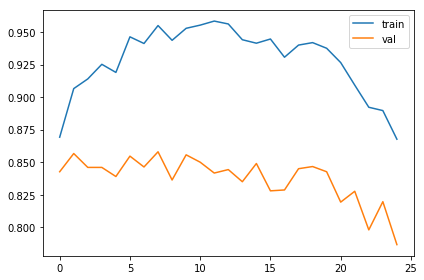

In [5]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

mlp = MLP([128,512,128,10],activation=[None,'ReLU','ReLU','softmax'], dropout=[0, 0.2, 0.2, 0])
losses, accuracies_train, accuracies_val = mlp.optimize(X_train, y_train, learning_rate=0.001, batch_size=1, momentum=0.9, weight_decay=0.0, epochs=25)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_val, label='val')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu.png')

In [163]:
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers, metrics, Sequential

import tensorflow
import tensorflow as tf
import keras
config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tensorflow.Session(config=config) 
keras.backend.set_session(sess)

import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

y = label
X = data

y_dummies = np.array(pd.get_dummies(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=0.25, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

with tf.device('GPU'):
    sgd = optimizers.sgd(lr=0.01)
    model = Sequential()
    model.add(Dense(128))
    #model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
    model.fit(X_train, y_train, batch_size=100, epochs=10)

#Predict and calculate accuracy
yhat_val = model.predict(X_val)

accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

print('Keras model accuracy : {}'.format(accuracy_val))

Epoch 1/10
45000/45000 [==============================] - 1s 24us/step - loss: 0.6924 - acc: 0.7761 - categorical_accuracy: 0.7761
Epoch 2/10
45000/45000 [==============================] - 1s 21us/step - loss: 0.3802 - acc: 0.8643 - categorical_accuracy: 0.8643
Epoch 3/10
45000/45000 [==============================] - 1s 21us/step - loss: 0.3382 - acc: 0.8790 - categorical_accuracy: 0.8790
Epoch 4/10
45000/45000 [==============================] - 1s 21us/step - loss: 0.3134 - acc: 0.8856 - categorical_accuracy: 0.8856
Epoch 5/10
45000/45000 [==============================] - 1s 20us/step - loss: 0.2941 - acc: 0.8928 - categorical_accuracy: 0.8928
Epoch 6/10
45000/45000 [==============================] - 1s 20us/step - loss: 0.2786 - acc: 0.8996 - categorical_accuracy: 0.8996
Epoch 7/10
45000/45000 [==============================] - 1s 20us/step - loss: 0.2652 - acc: 0.9025 - categorical_accuracy: 0.9025
Epoch 8/10
45000/45000 [==============================] - 1s 20us/step - loss: 0.25

## Optimizing settings

In [ ]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,512,128,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, batch_size=1,learning_rate=0.01,epochs=50)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

Epoch: 0..
train Accuracy: 0.8818888888888889 
Validation Accuracy: 0.8636666666666667 
Loss: 0.5236357078156707 

Epoch: 1..
train Accuracy: 0.8909777777777778 
Validation Accuracy: 0.8648 
Loss: 0.4007253480979453 

Epoch: 2..
train Accuracy: 0.9002 
Validation Accuracy: 0.8712 
Loss: 0.37435891861420717 

Epoch: 3..
train Accuracy: 0.8969555555555555 
Validation Accuracy: 0.8649333333333333 
Loss: 0.35990698710379204 

Epoch: 4..
train Accuracy: 0.9106 
Validation Accuracy: 0.8716666666666667 
Loss: 0.35167849340289126 

Epoch: 5..
train Accuracy: 0.9182444444444444 
Validation Accuracy: 0.8780666666666667 
Loss: 0.35096611376963815 

Epoch: 6..
train Accuracy: 0.9166222222222222 
Validation Accuracy: 0.8704 
Loss: 0.3399193994632599 

Epoch: 7..
train Accuracy: 0.9219777777777778 
Validation Accuracy: 0.8772 
Loss: 0.3484103883231853 

Epoch: 8..
train Accuracy: 0.9181333333333334 
Validation Accuracy: 0.8688666666666667 
Loss: 0.3508696647882877 

Epoch: 9..
train Accuracy: 0.9232

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in multiply


In [130]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.1,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

UnboundLocalError: local variable 'yhat_train' referenced before assignment

In [46]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,512,128,32,10],activation=[None, 'logistic', 'logistic', 'logistic', 'softmax'], dropout=[0.0, 0.0, 0.0, 0.0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.02,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

(1,)
(32,)


ValueError: shapes (32,) and (1,1) not aligned: 32 (dim 0) != 1 (dim 0)

In [107]:
import tensorflow
import tensorflow as tf
import keras
config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tensorflow.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


In [133]:
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers, metrics, Sequential

import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

y = label
X = data

y_dummies = np.array(pd.get_dummies(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=0.25, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

with tf.device('GPU'):
    sgd = optimizers.sgd(lr=0.1)
    model = Sequential()
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
    model.fit(X_train, y_train, batch_size=100, epochs=20)

#Predict and calculate accuracy
yhat_val = model.predict(X_val)

accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

print('Keras model accuracy : {}'.format(accuracy_val))

ValueError: Error when checking target: expected dense_24 to have shape (10,) but got array with shape (1,)

> c:\users\dnuho\anaconda3\envs\data\lib\site-packages\keras\engine\training_utils.py(138)standardize_input_data()
    136                             ': expected ' + names[i] + ' to have shape ' +
    137                             str(shape) + ' but got array with shape ' +
--> 138                             str(data_shape))
    139     return data
    140 

ipdb> q


## Crosscheck with Keras Library

In [ ]:
with tf.device('GPU'):
    sgd = optimizers.sgd()
    model = Sequential()
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
    model.fit(X_train, y_train, batch_size=100, epochs=20)

NameError: name 'tf' is not defined

> <ipython-input-117-4c2f6c2ef006>(1)<module>()
----> 1 with tf.device('GPU'):
      2     sgd = optimizers.sgd()
      3     model = Sequential()
      4     model.add(Dense(128))
      5     model.add(Dropout(0.2))



In [ ]:
#Predict and calculate accuracy
yhat_val = model.predict(X_val)

accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

print('Keras model accuracy : {}'.format(accuracy_val))